# Model Optimization

In [17]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine

In [3]:
# Load the data
dbpath = "postgresql://postgres@localhost:5432/asoup"
engine = create_engine(dbpath)
encoded_df = pd.read_sql("SELECT * FROM clean_data", engine).set_index("index")
encoded_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
index,,,,,,,,,,,,,,,,,,,,,
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Data Processing
We want to get rid of outliers, make sure data is good

count    3.429900e+04
mean     2.769199e+06
std      8.713045e+07
min      5.000000e+03
25%      5.000000e+03
50%      5.000000e+03
75%      7.742000e+03
max      8.597806e+09
Name: ASK_AMT, dtype: float64

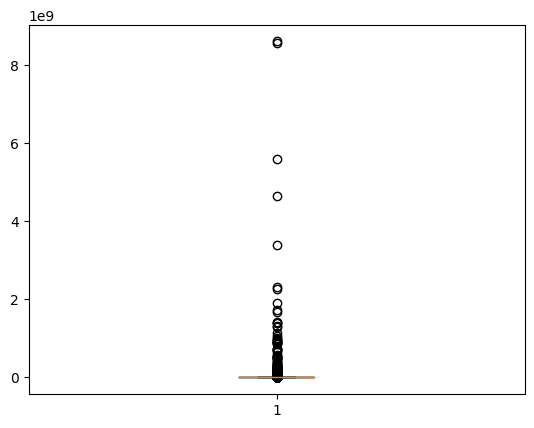

In [21]:
ask_amount = encoded_df["ASK_AMT"]
plt.boxplot(ask_amount)
ask_amount.describe()

In [136]:
# Helper function for organizing outliers data
def get_outliers_data(data: pd.Series, lower: float, upper: float) -> dict:
    """Returns a dictionary with the upper, lower limits, number and percentage of outliers."""
    outliers = data[(data < lower) | (data >= upper)]
    n_outliers = outliers.count()
    return outliers, {
        "upper_limit": upper,
        "lower_limit": lower,
        "n_outliers": n_outliers, 
        "percentage": f"{100* n_outliers / ask_amount.count():.2f}%"
    }

In [345]:
# Using IQR
q1 = ask_amount.quantile(0.25)
q3 = ask_amount.quantile(0.75)
iqr = q3 - q1
outliers_iqr, outliers_iqr_data = get_outliers_data(ask_amount, q1 - 1.5*iqr, q3 + 1.5*iqr)
outliers_iqr_data

{'upper_limit': 11855.0,
 'lower_limit': 887.0,
 'n_outliers': 8206,
 'percentage': '23.92%'}

In [346]:
# Using STD
std = ask_amount.std()
mean = ask_amount.mean()
outliers_std, outliers_std_data = get_outliers_data(ask_amount, mean - std*2, mean + std*2)
outliers_std_data

{'upper_limit': 177030103.5539489,
 'lower_limit': -171491706.18982753,
 'n_outliers': 80,
 'percentage': '0.23%'}

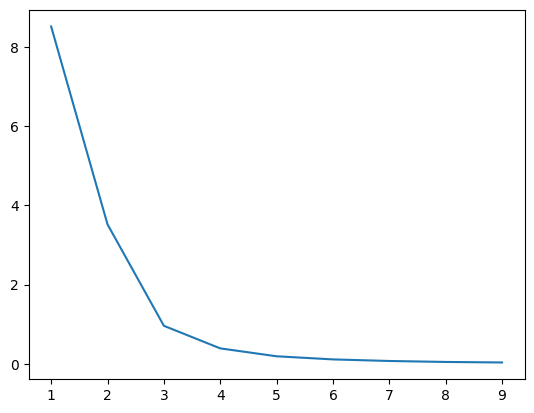

In [116]:
# Clustering with 2 dimensions of data
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

X = encoded_df[["ASK_AMT", "STATUS"]]
X_scaled = MinMaxScaler().fit_transform(X.values)
sse = pd.Series({k: KMeans(n_clusters=k).fit(X_scaled).inertia_ for k in range(1, 10)})
plt.plot(sse.index, sse.values)

In [140]:
# Cluster data
model = KMeans(n_clusters=4, random_state=1).fit(X_scaled)
combined = encoded_df.copy(deep=True)
combined["Cluster"] = model.predict(X_scaled)
print(combined["Cluster"].value_counts())
outliers_kmeans, outliers_kmeans_data = get_outliers_data(combined["Cluster"], 0, 1) # excluding lower and including upper
outliers_kmeans_data

0    34261
3       29
1        5
2        4
Name: Cluster, dtype: int64


{'upper_limit': 1, 'lower_limit': 0, 'n_outliers': 38, 'percentage': '0.11%'}

In [141]:
pd.DataFrame({"IQR": outliers_iqr_data, "STD": outliers_std_data, "KMeans": outliers_kmeans_data})

,IQR,STD,KMeans
upper_limit,11855.0,177030103.553949,1
lower_limit,887.0,-171491706.189828,0
n_outliers,8206,80,38
percentage,23.92%,0.23%,0.11%


# Outlier Filtering # 1
We are going to go with the data without the STD outliers as the percentage looks good.

In [305]:
# Split the Data
df = encoded_df.drop(outliers_std.index)
y = df["IS_SUCCESSFUL"].values
X = df.drop(["IS_SUCCESSFUL"], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# Scale the data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((25664, 43), (8555, 43))

In [287]:
# Replicating the previous model
nn_a = tf.keras.models.Sequential()
nn_a.add(tf.keras.layers.Dense(units=40, activation="relu", input_dim=len(X_train_scaled[0])))
nn_a.add(tf.keras.layers.Dense(units=20, activation="relu"))
nn_a.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
nn_a.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
nn_a.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 40)                1760      
                                                                 
 dense_89 (Dense)            (None, 20)                820       
                                                                 
 dense_90 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,601
Trainable params: 2,601
Non-trainable params: 0
_________________________________________________________________


In [288]:
fit_model = nn_a.fit(X_train_scaled, y_train, epochs=100, verbose=1)

Epoch 1/100
802/802 [==============================] - 2s 2ms/step - loss: 0.5735 - accuracy: 0.7180
Epoch 2/100
802/802 [==============================] - 1s 1ms/step - loss: 0.5558 - accuracy: 0.7294
Epoch 3/100
802/802 [==============================] - 1s 1ms/step - loss: 0.5530 - accuracy: 0.7295
Epoch 4/100
802/802 [==============================] - 1s 1ms/step - loss: 0.5511 - accuracy: 0.7309
Epoch 5/100
802/802 [==============================] - 1s 1ms/step - loss: 0.5500 - accuracy: 0.7324
Epoch 6/100
802/802 [==============================] - 1s 1ms/step - loss: 0.5486 - accuracy: 0.7321
Epoch 7/100
802/802 [==============================] - 1s 1ms/step - loss: 0.5481 - accuracy: 0.7320
Epoch 8/100
802/802 [==============================] - 1s 1ms/step - loss: 0.5475 - accuracy: 0.7318
Epoch 9/100
802/802 [==============================] - 1s 1ms/step - loss: 0.5474 - accuracy: 0.7324
Epoch 10/100
802/802 [==============================] - 1s 1ms/step - loss: 0.5465 - accura

In [289]:
# Eval Model
model_loss, model_accuracy = nn_a.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5598 - accuracy: 0.7282 - 429ms/epoch - 2ms/step
Loss: 0.5598382949829102, Accuracy: 0.7282291054725647


Model accuracy is not good enough!

In [282]:
# Storing the model
nn_a.save("trained_a.h5")

## Trying other Hyperparameters
We are going to keep the dataset the same and change hyperparameters

In [294]:
# Let's add another layer to have more interactions between variables
nn_b = tf.keras.models.Sequential()
nn_b.add(tf.keras.layers.Dense(units=60, activation="relu", input_dim=len(X_train_scaled[0])))
nn_b.add(tf.keras.layers.Dense(units=60, activation="tanh"))
nn_b.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
nn_b.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
nn_b.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 60)                2640      
                                                                 
 dense_95 (Dense)            (None, 60)                3660      
                                                                 
 dense_96 (Dense)            (None, 1)                 61        
                                                                 
Total params: 6,361
Trainable params: 6,361
Non-trainable params: 0
_________________________________________________________________


In [297]:
fit_model = nn_b.fit(X_train_scaled, y_train, epochs=120, verbose=1)

Epoch 1/120
802/802 [==============================] - 1s 2ms/step - loss: 0.5310 - accuracy: 0.7429
Epoch 2/120
802/802 [==============================] - 1s 1ms/step - loss: 0.5316 - accuracy: 0.7433
Epoch 3/120
802/802 [==============================] - 1s 1ms/step - loss: 0.5315 - accuracy: 0.7433
Epoch 4/120
802/802 [==============================] - 1s 1ms/step - loss: 0.5312 - accuracy: 0.7431
Epoch 5/120
802/802 [==============================] - 1s 2ms/step - loss: 0.5315 - accuracy: 0.7415
Epoch 6/120
802/802 [==============================] - 1s 2ms/step - loss: 0.5308 - accuracy: 0.7426
Epoch 7/120
802/802 [==============================] - 1s 1ms/step - loss: 0.5314 - accuracy: 0.7420
Epoch 8/120
802/802 [==============================] - 1s 2ms/step - loss: 0.5315 - accuracy: 0.7426
Epoch 9/120
802/802 [==============================] - 2s 2ms/step - loss: 0.5311 - accuracy: 0.7433
Epoch 10/120
802/802 [==============================] - 1s 1ms/step - loss: 0.5318 - accura

In [306]:
model_loss, model_accuracy = nn_b.evaluate(X_test_scaled, y_test, verbose=2)
nn_b.save("trained_b.h5")
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5650 - accuracy: 0.7245 - 353ms/epoch - 1ms/step
Loss: 0.5650394558906555, Accuracy: 0.7244886159896851


## Applying PCA
We have too many features, let's try reducing them to Principal Components.

0.9180860617839217

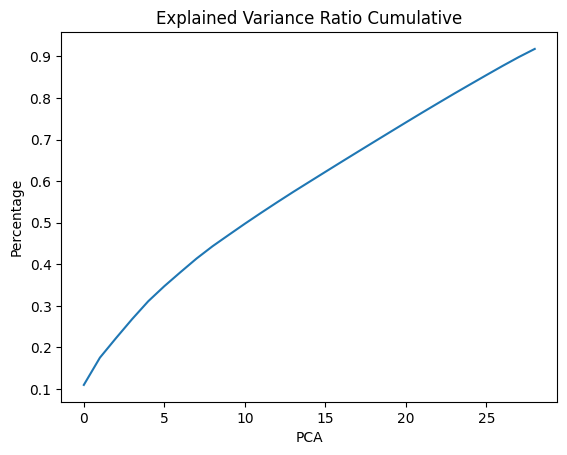

In [300]:
from sklearn.decomposition import PCA
import numpy as np

def get_explained_variance_ratio(df: pd.DataFrame, n_components: int):
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(df)
    return data, np.asarray(pca.explained_variance_ratio_)

N_COMPONENTS = 29
X_scaled = StandardScaler().fit_transform(X)
data, evr = get_explained_variance_ratio(X_scaled, N_COMPONENTS)
X_pca = pd.DataFrame(data, columns=[f"PC{x+1}" for x in range(N_COMPONENTS)])

plt.plot(np.cumsum(evr))
plt.title("Explained Variance Ratio Cumulative")
plt.xlabel("PCA")
plt.ylabel("Percentage")
sum(evr)

In [332]:
# Continuing PCA
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state=1)
# Scale for safety
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((25664, 29), (8555, 29))

## Last Manual Model Test
Using PCA, reducing neurons, adding layers

In [322]:
# Training 
nn_c = tf.keras.models.Sequential()
nn_c.add(tf.keras.layers.Dense(units=40, activation="relu", input_dim=len(X_train_scaled[0])))
nn_c.add(tf.keras.layers.Dense(units=10, activation="relu"))
nn_c.add(tf.keras.layers.Dense(units=10, activation="relu"))
nn_c.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
nn_c.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
nn_c.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_115 (Dense)           (None, 40)                1200      
                                                                 
 dense_116 (Dense)           (None, 10)                410       
                                                                 
 dense_117 (Dense)           (None, 10)                110       
                                                                 
 dense_118 (Dense)           (None, 1)                 11        
                                                                 
Total params: 1,731
Trainable params: 1,731
Non-trainable params: 0
_________________________________________________________________


In [323]:
fit_model = nn_c.fit(X_train_scaled, y_train, epochs=100, verbose=1)

Epoch 1/100
802/802 [==============================] - 2s 2ms/step - loss: 0.5887 - accuracy: 0.7096
Epoch 2/100
802/802 [==============================] - 1s 2ms/step - loss: 0.5584 - accuracy: 0.7294
Epoch 3/100
802/802 [==============================] - 1s 1ms/step - loss: 0.5557 - accuracy: 0.7294
Epoch 4/100
802/802 [==============================] - 1s 2ms/step - loss: 0.5538 - accuracy: 0.7306
Epoch 5/100
802/802 [==============================] - 1s 2ms/step - loss: 0.5527 - accuracy: 0.7304
Epoch 6/100
802/802 [==============================] - 1s 1ms/step - loss: 0.5511 - accuracy: 0.7315
Epoch 7/100
802/802 [==============================] - 2s 2ms/step - loss: 0.5510 - accuracy: 0.7316
Epoch 8/100
802/802 [==============================] - 2s 2ms/step - loss: 0.5498 - accuracy: 0.7318
Epoch 9/100
802/802 [==============================] - 1s 2ms/step - loss: 0.5496 - accuracy: 0.7309
Epoch 10/100
802/802 [==============================] - 1s 2ms/step - loss: 0.5488 - accura

In [324]:
model_loss, model_accuracy = nn_c.evaluate(X_test_scaled, y_test, verbose=2)
nn_c.save("trained_c.h5")
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5569 - accuracy: 0.7281 - 447ms/epoch - 2ms/step
Loss: 0.5568825602531433, Accuracy: 0.7281122207641602


## Using Keras Optimizer

In [336]:
import keras_tuner as kt

def create_model(hp: kt.HyperParameters) -> tf.keras.Model:
    """Uses the HyperParameters from a Keras Tuner and returns a Keras Model"""
    nn_model = tf.keras.models.Sequential()

    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    nn_model.add(
        tf.keras.layers.Dense(
            units=hp.Int(
                'first_units',
                min_value=1,
                max_value=10,
                step=2,
            ),
                activation=activation,
                input_dim=len(X_train_scaled[0])
        ))
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(
            tf.keras.layers.Dense(
                units=hp.Int(
                    'units_' + str(i),
                    min_value=1,
                    max_value=10,
                    step=2,
                ),
                activation=activation
            ))
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    nn_model.compile(
        loss="binary_crossentropy",
        optimizer='adam',
        metrics=['accuracy'],
    )
    return nn_model

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2
)
print(create_model)
print(tuner)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
<function create_model at 0x13ca44560>


In [338]:
# applying the tuner to the PCA values
tuner.search(X_train_scaled, y_train, epochs=20, validation_data=(X_test_scaled, y_test), verbose=1)

Trial 60 Complete [00h 00m 33s]
val_accuracy: 0.7240210175514221

Best val_accuracy So Far: 0.726475715637207
Total elapsed time: 00h 15m 02s
INFO:tensorflow:Oracle triggered exit


In [339]:
# getting the best hyper
best_hyper = tuner.get_best_hyperparameters(1)[0]
print(best_hyper.values)

{'activation': 'tanh', 'first_units': 7, 'num_layers': 4, 'units_0': 7, 'units_1': 7, 'units_2': 5, 'units_3': 9, 'units_4': 7, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0014'}


In [340]:
# Getting the best model
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5572 - accuracy: 0.7265 - 793ms/epoch - 3ms/step
Loss: 0.5571862459182739, Accuracy: 0.726475715637207


In [358]:
# Best model with more epochs
best_model.fit(X_train_scaled, y_train, epochs=100, verbose=1)

Epoch 1/100
612/612 [==============================] - 2s 2ms/step - loss: 0.5533 - accuracy: 0.7476
Epoch 2/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5530 - accuracy: 0.7486
Epoch 3/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5522 - accuracy: 0.7483
Epoch 4/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5519 - accuracy: 0.7475
Epoch 5/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5519 - accuracy: 0.7478
Epoch 6/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5516 - accuracy: 0.7486
Epoch 7/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5510 - accuracy: 0.7487
Epoch 8/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5508 - accuracy: 0.7493
Epoch 9/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5509 - accuracy: 0.7483
Epoch 10/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5504 - accura

In [359]:
model_loss, model_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

204/204 - 0s - loss: 0.5435 - accuracy: 0.7391 - 249ms/epoch - 1ms/step
Loss: 0.5435408353805542, Accuracy: 0.7391170859336853


# Using IQR-filtered Data
We won't give up!

In [352]:
df = encoded_df.drop(outliers_iqr.index)
y = df["IS_SUCCESSFUL"].values
X = df.drop(["IS_SUCCESSFUL"], axis=1).values

def get_explained_variance_ratio(df: pd.DataFrame, n_components: int):
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(df)
    return data, np.asarray(pca.explained_variance_ratio_)

N_COMPONENTS = 29
X_scaled = StandardScaler().fit_transform(X)
data, evr = get_explained_variance_ratio(X_scaled, N_COMPONENTS)
X_pca = pd.DataFrame(data, columns=[f"PC{x+1}" for x in range(N_COMPONENTS)])
X_pca.shape, sum(evr)

((26093, 29), 0.9083105427341529)

In [354]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state=1)
# Scale the data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((19569, 29), (6524, 29))

In [355]:
# Tuner Search with the IQR-filtered data
tuner.search(X_train_scaled, y_train, epochs=20, validation_data=(X_test_scaled, y_test), verbose=1)

Trial 72 Complete [00h 00m 28s]
val_accuracy: 0.7401900887489319

Best val_accuracy So Far: 0.7420294284820557
Total elapsed time: 00h 24m 19s
INFO:tensorflow:Oracle triggered exit


In [356]:
best_hyper = tuner.get_best_hyperparameters(1)[0]
print(best_hyper.values)

{'activation': 'relu', 'first_units': 3, 'num_layers': 3, 'units_0': 5, 'units_1': 7, 'units_2': 7, 'units_3': 9, 'units_4': 5, 'units_5': 5, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [357]:
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

204/204 - 1s - loss: 0.5611 - accuracy: 0.7420 - 719ms/epoch - 4ms/step
Loss: 0.5610514879226685, Accuracy: 0.7420294284820557


In [360]:
best_model.fit(X_train_scaled, y_train, epochs=100, verbose=1)

Epoch 1/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5318 - accuracy: 0.7494
Epoch 2/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5325 - accuracy: 0.7496
Epoch 3/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5316 - accuracy: 0.7498
Epoch 4/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5315 - accuracy: 0.7497
Epoch 5/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5314 - accuracy: 0.7496
Epoch 6/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5317 - accuracy: 0.7511
Epoch 7/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5317 - accuracy: 0.7493
Epoch 8/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5313 - accuracy: 0.7494
Epoch 9/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5312 - accuracy: 0.7507
Epoch 10/100
612/612 [==============================] - 1s 2ms/step - loss: 0.5321 - accura

In [361]:
model_loss, model_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

204/204 - 0s - loss: 0.5454 - accuracy: 0.7371 - 233ms/epoch - 1ms/step
Loss: 0.5454042553901672, Accuracy: 0.7371244430541992


We tried!